# [Deep Learning & Art: Neural Style Transfer](#deep-learning-art-neural-style-transfer)

<a name="deep-learning-art-neural-style-transfer"></a>

## Overview

In this notebook, we delve into **Neural Style Transfer (NST)**, an innovative algorithm introduced by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) that combines deep learning and artistic creativity. Neural Style Transfer enables the synthesis of novel artistic images by blending the content of one image with the style of another, creating visually compelling results that mimic distinct artistic aesthetics.

## Objectives

Through this exploration of Neural Style Transfer, we aim to:
- Develop an implementation of the NST algorithm.
- Generate unique, art-inspired images by applying the algorithm to diverse content and style images.
- Construct and understand the **style cost function**, which captures the stylistic essence of an image.
- Define the **content cost function**, which preserves the structural integrity of the content image.

## Background

Most machine learning algorithms optimize a cost function to learn an optimal set of parameter values for a given task. In the case of Neural Style Transfer, however, we are optimizing a cost function to modify **pixel values** directly, creating a new image that integrates the stylistic elements of one image with the content of another. This marks a significant departure from traditional deep learning objectives, presenting both technical challenges and creative possibilities.



## Table of Contents

- [1 - Packages](#1)
- [2 - Problem Statement](#2)
- [3 - Transfer Learning](#3)
- [4 - Neural Style Transfer (NST)](#4)
    - [4.1 - Content Cost](#4-1)
        - [4.1.1 - Make Generated Image G Match the Content of Image C](#4-1-1)
        - [4.1.2 - Content Cost Function  𝐽𝑐𝑜𝑛𝑡𝑒𝑛𝑡(𝐶,𝐺)](#4-1-2)
        - [4.1.3 - Computing the Content Cost](#4-1-3)
    - [4.2 - Style Cost](#4-2)
        - [4.2.1 - Style Matrix](#4-2-1)
        - [4.2.2 - How to Compute Gram Matrix $G_{gram}$](#4-2-2)
        - [4.2.3 - Compute Gram Matrix](#4-2-3)
        - [4.2.4 - How to compute Layer Style Cost](#4-2-4)
        - [4.2.5 - Compute Layer Style Cost](#4-2-5)
    - [4.3 - Neural Style Transfer and diffrent layers](#4-3)
        - [4.3.1 - Layer Names](#4-3.1)
        - [4.3.2 - Content layer](#4-3.2)
        - [4.3.3 - Choosing Style Layers and Assigning Style Costs Weights](#4-3.3)
        - [4.3.4 - Style Weights](#4-3-4)
        - [4.3.5 - Combining Style Costs from Multiple Layers](#4-3-5)
        - [4.3.6 - Computing the Total Style Cost](#4-3-6)
    - [4.4 - Defining the Total Cost to Optimize](#4-4)
        - [4.4.1 - Computing the Total Cost to Optimize](#4-4-1)
- [5 - Solving the Optimization Problem](#5)
    - [5.1 Load the Content Image](#5-1)
    - [5.2 Load the Style Image](#5-2)
    - [5.3 Randomly Initialize the Image to be Generated](#5-3)
    - [5.4 - Load Pre-trained VGG19 Model](#5-4)
    - [5.5 - Compute Total Cost](#5-5)
        - [5.5.1 - Compute Content Cost](#5-5-1)
        - [5.5.2 - Compute Style Cost](#5-5-2)
    - [5.6 - Train the Model](#5-6)
        - [5.6.1 - Image Display Utilities](#5-6-1)
        - [5.6.2 - Implementing a train_step](#5-6-2)
        - [5.6.3 - Train the Model](#5-6-3)
        - [5.6.4 - Generated Image Results](#5-6-4)
- [6 - Conclusion](#6)
    - [6.1 - Key Takeaways](#6-1)
- [7 - References](#7)




<a name='1'></a>
## [1 - Packages](#1)

In this section, we import essential packages and dependencies required to implement Neural Style Transfer. These libraries provide foundational tools for constructing, training, and optimizing deep learning models, allowing us to efficiently execute image processing tasks involved in the style transfer process.

The primary libraries utilized include:
- **NumPy**: For numerical operations and matrix manipulation.
- **PIL (Python Imaging Library)**: For image processing tasks, such as loading and transforming images.
- **TensorFlow / PyTorch**: For building and training the neural network models that enable style transfer.


In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.applications import VGG19
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

2024-11-06 12:54:16.156200: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 12:54:16.377211: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 12:54:16.499879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730897656.718542    3089 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730897656.782204    3089 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 12:54:17.052023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

<a name='2'></a>
## [2 - Problem Statement](#2)

Neural Style Transfer (NST) is a fascinating optimization technique within deep learning that synthesizes a new image by blending two distinct sources: a **content image (C)** and a **style image (S)**. The algorithm generates a third image, the **generated image (G)**, which retains the "content" from image C while adopting the "style" from image S.

In this project, we apply NST to create an artwork that combines a photograph of the Louvre Museum in Paris (content image C) with the impressionistic style of Claude Monet (style image S), resulting in the following synthesized image:

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

This approach offers a unique exploration of art and deep learning, demonstrating the creative potential of neural networks through the generation of art-inspired compositions.


<a name='3'></a>
## [3 - Transfer Learning](#3)

Neural Style Transfer (NST) leverages **transfer learning**, a technique where a model trained on one task is adapted to perform a different task. Specifically, NST utilizes a pre-trained convolutional neural network as the foundation for style and content extraction. This approach allows us to harness the capabilities of a high-performing model without requiring extensive retraining.

In this implementation, we use the **VGG-19 network** from the [original NST paper](https://arxiv.org/abs/1508.06576) by the Visual Geometry Group at the University of Oxford. VGG-19, a 19-layer version of the VGG network, was pre-trained on the expansive ImageNet database. This training enables it to identify a wide range of low-level features (in shallower layers) and high-level features (in deeper layers), making it highly effective for NST.

The code below loads the parameters from the VGG-19 model.


In [3]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400

vgg = VGG19(include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
vgg.trainable = False
pp.pprint(vgg)


2024-11-06 12:54:20.484313: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<Functional name=vgg19, built=True>


<a name='4'></a>
## [4 - Neural Style Transfer (NST)](#4)

In this section, we will construct the **Neural Style Transfer (NST)** algorithm, following a systematic approach that involves three key steps:

1. **Building the Content Cost Function**: We will define the content cost function $J_{\text{content}}(C,G)$, which quantifies the difference between the content of the content image $C$ and the generated image $G$.

2. **Building the Style Cost Function**: Next, we will develop the style cost function $J_{\text{style}}(S,G)$, which measures the stylistic resemblance between the style image $S$ and the generated image $G$.

3. **Combining the Cost Functions**: Finally, we will integrate these components to formulate the total cost function $J(G) = \alpha J_{\text{content}}(C,G) + \beta J_{\text{style}}(S,G)$, where $\alpha$ and $\beta$ are weighting parameters that balance the contributions of content and style.

This structured approach allows us to effectively optimize the generated image, ensuring that it retains the desired content while embodying the chosen artistic style. Let’s proceed with the implementation of these cost functions!


<a name='4-1'></a>
### [4.1 - Content Cost](#4-1)

<a name='4-1-1'></a>
#### [4.1.1 - Make Generated Image G Match the Content of Image C](#4-1-1)

A key objective when performing Neural Style Transfer (NST) is to ensure that the content in the generated image $G$ aligns closely with the content of the image $C$. Achieving this involves understanding the concept of **shallow versus deep layers** in convolutional networks:


- The shallower layers of a ConvNet tend to detect lower-level features such as *edges and simple textures*.
- The deeper layers, on the other hand, are responsible for identifying higher-level features, including more *complex textures and object classes*.

#### Choosing a "Middle" Activation Layer $a^{[l]}$:
To effectively capture the content of image $C$, it is advantageous to select activations from a layer that represents a balance of features. 

- Selecting a layer in the **middle** of the network—neither too shallow nor too deep—allows the network to capture both higher-level and lower-level features. This approach can lead to more visually appealing results.


#### Forward Propagating Image "C":
- Set the image $C$ as the input to the pre-trained VGG network and perform forward propagation. 
- Let $a^{(C)}$ denote the hidden layer activations from the chosen layer. In this context, we simplify the notation by omitting the superscript $[l]$. Thus, $a^{(C)}$ will be a tensor of shape $n_H \times n_W \times n_C$.

#### Forward Propagating Image "G":
- This process is repeated with the image $G$, setting $G$ as the input to the network and running forward propagation.
- Let $a^{(G)}$ represent the corresponding hidden layer activation for the generated image.


In this scenario, the content image $C$ will be the picture of the Louvre Museum in Paris. Below, we visualize the content image $C$.



The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


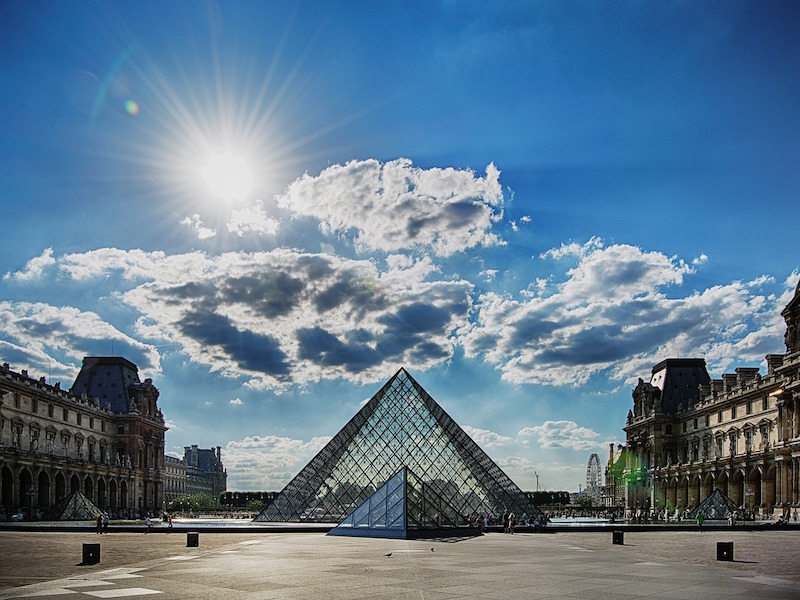

In [4]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

<a name='4-1-2'></a>
#### [4.1.2 - Content Cost Function $J_{\text{content}}(C,G)$](#4-1-2)

A fundamental aspect of Neural Style Transfer (NST) is ensuring that the content in the generated image $G$ aligns with that of the image $C$. To achieve this, we define the **content cost function**, given by:

$$
J_{\text{content}}(C,G) = \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{\text{all entries}} (a^{(C)} - a^{(G)})^2 \tag{1}
$$

- In this equation, $n_H$, $n_W$, and $n_C$ represent the height, width, and number of channels of the chosen hidden layer, respectively. These parameters appear in a normalization term within the cost function.
- For clarity, it is important to note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to the activations of the hidden layer.
- To compute the cost $J_{\text{content}}(C,G)$ effectively, it may be advantageous to unroll these 3D volumes into a 2D matrix, as illustrated below. 
- Although this unrolling step is not strictly necessary for computing $J_{\text{content}}$, it serves as good practice for similar operations required when calculating the style cost $J_{\text{style}}$.

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

By calculating this cost function, we quantify the disparity between the content representations of the two images, guiding the optimization of the generated image towards the desired content.


<a name='4-1-3'></a>
#### [4.1.3 - Computing the Content Cost](#4-1-3)

In this section, we focus on computing the **content cost** using TensorFlow. 

To facilitate this process, we utilize the hidden layer activations representing the content of the images:

- `a_G`: Hidden layer activations representing the content of the generated image $G$.
- `a_C`: Hidden layer activations representing the content of the image $C$.

The implementation of this function involves the following steps:
1. **Retrieve Dimensions from `a_G`**: 
   - Dimensions from a tensor `X` can be extracted using: `X.get_shape().as_list()`
2. **Unroll `a_C` and `a_G`**: 
   - The goal is to reshape these activations as described in the earlier sections. 
   - Useful functions for this purpose include [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) and [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape).
3. **Compute the Content Cost**: 
    - To compute the cost, we'll likely want to use these functions: [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract).
    
    
#### Additional Hints for "Unrolling"
- To unroll the tensor, we aim to change the shape from $(m,n_H,n_W,n_C)$ to $(m, n_H \times n_W, n_C)$.
- The function `tf.reshape(tensor, shape)` accepts a list of integers representing the desired output shape. 
 By specifying `-1` for the `shape` parameter, we allow the function to determine the appropriate dimension size, ensuring the output tensor contains all values from the original tensor.
    - So `tf.reshape(a_C, shape=[m, n_H * n_W, n_C])` gives the same result as `tf.reshape(a_C, shape=[m, -1, n_C])`.
- If reordering dimensions is necessary, the `tf.transpose(tensor, perm)` function can be employed, where `perm` is a list of integers indicating the original indices of the dimensions. 
    - For example, `tf.transpose(a_C, perm=[0,3,1,2])` changes the dimensions from $(m, n_H, n_W, n_C)$ to $(m, n_C, n_H, n_W)$.
      
This structured approach will effectively guide the calculation of the content cost while reinforcing the understanding of tensor manipulation in TensorFlow.


In [5]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost for the content-based image style transfer.
    
    Arguments:
    content_output -- tensor of shape (1, n_H, n_W, n_C), activations from the content image
    generated_output -- tensor of shape (1, n_H, n_W, n_C), activations from the generated image
    
    Returns: 
    J_content -- scalar representing the content cost
    """
    # Extract the last layer activations for content and generated images
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions of the activations (batch size, height, width, channels)
    shape = tf.shape(a_C)
    m, n_H, n_W, n_C = shape[0], shape[1], shape[2], shape[3]
    
    # Reshape activations into 2D matrices of shape (m, n_H * n_W, n_C) for simplified computation
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
    # Compute the content cost using mean squared error between content and generated activations
    # Ensure the denominator is cast to float
    denominator = tf.cast(n_H * n_W * n_C, tf.float32) * 4.0
    J_content = (1 / denominator) * tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))
    
    return J_content

In [6]:

def close_enough(value, target, tol=1e-6):
    """Helper function to check if two tensors are close within a tolerance."""
    return tf.reduce_all(tf.abs(value - target) < tol)

# Testing the function with random tensors
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)

# Calculate content cost
J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])

# Assertions for testing
assert isinstance(J_content, tf.Tensor), "Output should be a TensorFlow tensor"
assert close_enough(J_content_0, 0.0), "compute_content_cost(a_C, a_C) must be 0"
assert close_enough(J_content, 7.0568767), f"Expected value: 7.0568767, but got {J_content.numpy()}"

print("J_content =", J_content.numpy())
print("J_content =", J_content_0.numpy())


J_content = 7.056877
J_content = 0.0


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_content</b>  
        </td>
        <td>
            7.0568767
        </td>
    </tr>

</table>


<br>
<font color='blue'>

**Key Takeaways:**

- The content cost quantifies the difference between the hidden layer activations $a^{(C)}$ and $a^{(G)}$ of the neural network.
- Minimizing the content cost during the optimization process ensures that the generated image $G$ retains content similarity to the image $C$.

</font>



<a name='4-2'></a>
### [4.2 - Style Cost](#4-2)

In this section, we will focus on computing the **style cost** associated with Neural Style Transfer. The style cost measures how closely the generated image $G$ aligns with the stylistic features of the style image $S$. 

To illustrate this process, we will utilize a specific style image in our example:


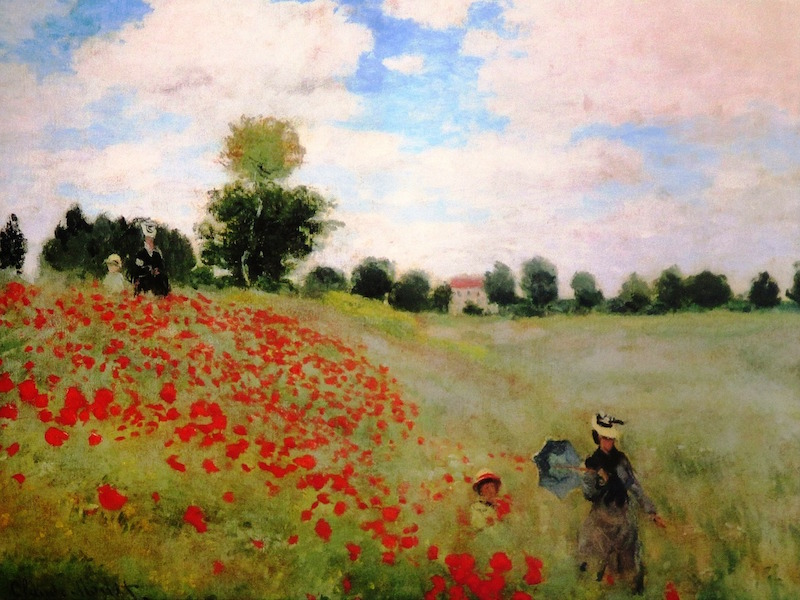

In [7]:
example = Image.open("images/monet_800600.jpg")
example

This was painted in the style of <b>[impressionism](https://en.wikipedia.org/wiki/Impressionism)</b>.

Now let's see how we can now define a "style" cost function $J_{style}(S,G)$!

<a name='4-2-1'></a>
#### [4.2.1 - Style Matrix](#4-2-1)


In the context of Neural Style Transfer, the **style matrix** is commonly referred to as the **Gram matrix**. The Gram matrix serves as a vital component in capturing the stylistic characteristics of an image.

- In linear algebra, the Gram matrix $G$ of a set of vectors $(v_{1},\dots ,v_{n})$ is defined as the matrix of dot products, where the entries are given by:
  
  $$ G_{ij} = v_{i}^T v_{j} = \text{np.dot}(v_{i}, v_{j}) $$

- This formulation means that $G_{ij}$ measures the similarity between the vectors $v_i$ and $v_j$. If the vectors are highly similar, we expect a large dot product, resulting in a larger value for $G_{ij}$.

##### Two Meanings of the Variable $G$

It is important to note that there is a potential for confusion with the variable names used in this context:

- **$G$** denotes both the Gram matrix (style matrix) and the generated image. To avoid ambiguity, we will adopt the following conventions:
  - Use **$G_{gram}$** to refer specifically to the Gram matrix.
  - Use **$G$** to represent the generated image.

By clarifying these terms, we ensure a more precise discussion of the relationships and calculations involved in the Neural Style Transfer process.


<a name='4-2-2'></a>
#### [4.2.2 - How to Compute Gram Matrix $G_{gram}$](#4-2-2)

To compute the **Style matrix** (or Gram matrix), we utilize the unrolled filter activations. The Gram matrix is derived by multiplying the unrolled activation matrix by its transpose:

$$ \mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T $$

<img src="images/NST_GM.png" style="width:900px;height:300px;">

The resulting Gram matrix $\mathbf{G}_{gram}$ is of dimension $(n_C, n_C)$, where $n_C$ represents the number of filters (channels) in the layer being analyzed. 

##### $G_{(gram)ij}$: Correlation

The entry $G_{(gram)ij}$ indicates the correlation between the activations of filter $i$ and filter $j$. A higher value suggests that the corresponding features captured by these filters occur together frequently within the image.

##### $G_{(gram),ii}$: Prevalence of Patterns or Textures

- The diagonal elements $G_{(gram)ii}$ quantify how "active" filter $i$ is across the image.
- For instance, if filter $i$ is responsible for detecting vertical textures, then $G_{(gram)ii}$ measures the prevalence of these vertical textures in the overall image. A large value for $G_{(gram)ii}$ indicates that the image contains significant vertical texture.

By capturing both the prevalence of distinct features ($G_{(gram)ii}$) and the co-occurrence of different features ($G_{(gram)ij}$), the Gram matrix $G_{gram}$ effectively encapsulates the stylistic attributes of an image.


<a name='4-2-3'></a>
#### [4.2.3 - Compute Gram Matrix](#4-2-3)

In this section, we focus on implementing a function to compute the Gram matrix of a given matrix $A$. The Gram matrix can be defined using the following formula:

$$ G_A = AA^T $$

To achieve this, we will utilize TensorFlow operations. Specifically, we will leverage the matrix multiplication and transpose functionalities provided by TensorFlow.

The key steps for this implementation include:

1. **Matrix Multiplication**: We will use the `tf.matmul` function to compute the product of the matrix $A$ and its transpose.
2. **Transpose**: The `tf.transpose` function will facilitate obtaining the transpose of the matrix.


In [8]:
def gram_matrix(A):
    """
    Computes the Gram matrix for a given matrix A.
    
    Arguments:
    A -- matrix of shape (n_C, n_H * n_W), where n_C is the number of channels,
         and n_H * n_W is the flattened spatial dimension of each channel.
    
    Returns:
    GA -- Gram matrix of shape (n_C, n_C), representing the correlations between channels.
    """
    # Compute the Gram matrix by multiplying A with its transpose
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [9]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

assert type(GA) == EagerTensor, "Use the tensorflow function"
assert GA.shape == (3, 3), "Wrong shape. Check the order of the matmul parameters"
assert np.allclose(GA[0,:], [63.1888, -26.721275, -7.7320204]), "Wrong values."

print("GA = \n" + str(GA))

print("\033[92mAll tests passed")

GA = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>GA</b>
        </td>
        <td>
           [[ 63.1888    -26.721275   -7.7320204] <br>
 [-26.721275   12.76758    -2.5158243] <br>
 [ -7.7320204  -2.5158243  23.752384 ]] <br>
        </td>
    </tr>

</table>

<a name='4-2-4'></a>
#### [4.2.4 - How to compute Layer Style Cost](#4-2-4)

Having computed the Gram matrix, we can now define the **style cost** associated with Neural Style Transfer. The primary objective is to minimize the distance between the Gram matrix of the "style" image $S$ and the Gram matrix of the "generated" image $G$. 

For our calculations, we will focus on a single hidden layer $a^{[l]}$. The style cost for this layer is mathematically defined as follows:

$$ J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C} \sum_{j=1}^{n_C} (G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2 \tag{2} $$

Where:
- $G_{gram}^{(S)}$ is the Gram matrix of the "style" image.
- $G_{gram}^{(G)}$ is the Gram matrix of the "generated" image.
- The cost is computed using the hidden layer activations corresponding to a specific layer $a^{[l]}$ in the neural network.

This formulation enables us to capture the essence of the artistic style of the input image $S$ and assess how closely the generated image $G$ replicates this style, thus guiding the optimization process in Neural Style Transfer.



<a name='4-2-5'></a>
#### [4.2.5 - Compute Layer Style Cost](#4-2-5)

In this section, we will compute the style cost for a single layer in the context of Neural Style Transfer. This process is essential for evaluating how well the generated image $G$ reflects the style of the style image $S$. The following steps outline the methodology to achieve this:

**Implementation Steps**:

1. **Retrieve Dimensions**: 
   - First, we will extract the dimensions from the hidden layer activations of the generated image, denoted as $a_G$. This is accomplished using the method: 
     ```python
     dimensions = a_G.get_shape().as_list()
     ```

2. **Unroll Activations**: 
   - Next, we will reshape the hidden layer activations of both the style image $a_S$ and the generated image $a_G$ into 2D matrices. This transformation is crucial for calculating the Gram matrix effectively. We can use functions such as `tf.transpose` and `tf.reshape` to accomplish this unrolling.

3. **Compute Gram Matrices**: 
   - Utilizing the unrolled matrices, we will compute the Gram matrices for both images. This involves applying the previously defined function for computing the Gram matrix.

4. **Calculate Style Cost**: 
   - Finally, we will calculate the style cost using the formula established earlier. This involves assessing the differences between the Gram matrices of the style image and the generated image. Functions such as `tf.reduce_sum`, `tf.square`, and `tf.subtract` will be useful here.
     ```

#### Additional Hints
- It is important to note that the activation dimensions are structured as $(m, n_H, n_W, n_C)$, where $m$ represents the batch size, $n_H$ the height, $n_W$ the width, and $n_C$ the number of channels. The desired unrolled matrix shape is $(n_C, n_H \times n_W)$. Thus, the order of the filter dimension $n_C$ is changed during unrolling. The `tf.transpose` function can be used to adjust the order of the dimensions accordingly.


In [10]:
def compute_layer_style_cost(a_S, a_G):
    """
    Computes the style cost for a given layer in the style transfer model.
    
    Arguments:
    a_S -- tensor of shape (1, n_H, n_W, n_C), activations of the style image
    a_G -- tensor of shape (1, n_H, n_W, n_C), activations of the generated image
    
    Returns:
    J_style_layer -- tensor representing the style cost between the two images
    """
    # Retrieve dimensions using tf.shape for dynamic shape retrieval
    shape = tf.shape(a_G)  # same as a_S in this case
    n_H, n_W, n_C = shape[1], shape[2], shape[3]
    
    # Reshape activations to 2D: (n_H * n_W, n_C)
    a_S_reshaped = tf.reshape(a_S, [n_H * n_W, n_C])
    a_G_reshaped = tf.reshape(a_G, [n_H * n_W, n_C])
    
    # Compute Gram matrices for style and generated images
    GS = gram_matrix(a_S_reshaped)
    GG = gram_matrix(a_G_reshaped)
    
    # Ensure the denominator is cast to float32
    denominator = 4.0 * tf.cast(n_C**2 * (n_H * n_W)**2, tf.float32)
    
    # Compute the style cost as the mean squared error between the Gram matrices
    J_style_layer = tf.reduce_sum(tf.square(GS - GG)) / denominator
    
    return J_style_layer

In [11]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)

print("J_style_layer = " + str(J_style_layer_SG))

assert type(J_style_layer_GG) == EagerTensor, "Use the tensorflow functions"
assert np.isclose(J_style_layer_GG, 0.0), "Wrong value. compute_layer_style_cost(A, A) must be 0"
assert J_style_layer_SG > 0, "Wrong value. compute_layer_style_cost(A, B) must be greater than 0 if A != B"
assert np.isclose(J_style_layer_SG, 14.017805), "Wrong value."




J_style_layer = tf.Tensor(29.538082, shape=(), dtype=float32)


AssertionError: Wrong value.

<a name='4-3'></a>
### [4.3 - Neural Style Transfer and diffrent layers](#4-3)


#### [4.3.1 - Layer Names](#4-3.1)

To effectively implement the Neural Style Transfer (NST) framework, we first need to identify the layers of the convolutional neural network that will be used to extract style information. Below is a list of commonly used layers in the VGG-19 architecture, which is popular for NST tasks:

In [12]:
for layer in vgg.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


#### [4.3.2 - Content layer](#4-3.2)

We have choosed `block5_conv4` layer from the VGG-19 model as our **content layer**. We can examine the activations generated when a specific input image is processed through this layer. This layer is typically used as the **content layer** in the Neural Style Transfer (NST) process because it captures high-level features of the image, effectively representing the content. We will visualize the output of the `block5_conv4` layer from the VGG-19 model.


In [13]:
vgg.get_layer('block5_conv4').output

<KerasTensor shape=(None, 25, 25, 512), dtype=float32, sparse=False, name=keras_tensor_20>

 #### [4.3.3 - Choosing Style Layers and Assigning Style Costs Weights](#4-3.3)

To effectively capture the style of an image in the Neural Style Transfer (NST) process, it is beneficial to utilize multiple layers from the VGG-19 model. Each layer contributes to the overall style representation, and assigning weights allows us to control the influence of each layer on the final stylization.

##### Selected Style Layers
The following layers have been chosen to represent the style of the image:


In [14]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

<a name='4-3-4'></a>
#### [4.3.4 - Style Weights](#4-3-4)

To enhance the quality of the generated image in Neural Style Transfer (NST), it is beneficial to capture style information from multiple layers of the neural network rather than relying on a single layer. By merging the style costs from various layers, we can achieve a more nuanced and comprehensive representation of the style. This process involves the following steps:

- **Layer Contribution**: Each layer is assigned a weight, denoted as $\lambda^{[l]}$, which determines its contribution to the overall style cost. These weights can be tuned to balance the influence of each layer in the final output.

- **Normalization of Weights**: It is essential to ensure that the sum of the weights across all selected layers equals 1. This normalization allows for a balanced integration of style information:
  $$
  \sum_{l=1}^{L} \lambda^{[l]} = 1
  $$

- **Experimentation**: We encourage exploration of different weight configurations. This experimentation can yield insights into how varying the contributions of specific layers affects the characteristics of the generated image $G$.

By thoughtfully applying style weights, we can refine the generated output to better capture the desired stylistic attributes while maintaining the content integrity of the input image.


<a name='4-3-5'></a>
#### [4.3.5 - Combining Style Costs from Multiple Layers](#4-3-5)

To compute the overall style cost for the Neural Style Transfer (NST) algorithm, we can combine the style costs from different layers using the following formula:

$$
J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)
$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 

#### [4.3.6 - Computing the Total Style Cost](#4-3-6)

To compute the total style cost for the Neural Style Transfer (NST) process, we can utilize a function that aggregates the style costs from multiple layers based on predefined weights. The function `compute_style_cost(...)` operates as follows:

#### Description of `compute_style_cost`

1. **Initialize Total Style Cost**: Begin with a variable to accumulate the overall style cost, initialized to zero.

2. **Iterate Over Style Layers**:
    - For each layer specified in `STYLE_LAYERS`, the function performs the following steps:
      - **Activation Retrieval**: Obtain the activation (output tensor) from the current layer for both the style image \(S\) and the generated image \(G\).
      - **Compute Style Cost**: Utilize the previously defined function `compute_layer_style_cost(...)` to calculate the style cost for the current layer.
      - **Weighted Contribution**: Multiply the computed style cost by the corresponding weight \(\lambda^{[l]}\) from `STYLE_LAYERS`.
      - **Accumulate**: Add this weighted style cost to the overall style cost variable.

3. **Return Total Style Cost**: After processing all specified layers, the function returns the computed total style cost \(J_{style}(S,G)\).

This systematic approach ensures that the style representation captures the contributions from various layers, each weighted according to its significance in the overall style transfer process.


In [15]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not to be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the array contains the content layer image, which must not to be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

When determining the coefficients for the style layers in Neural Style Transfer (NST), it is essential to consider the role of each layer in capturing the visual characteristics of the style image. Here are some guidelines for selecting the weights for each layer:

1. **Understanding Layer Contributions**:
   - **Deeper Layers**: These layers capture more abstract, high-level features of the image, such as shapes and complex textures. They represent broader characteristics of the style.
   - **Shallower Layers**: These layers tend to capture finer details, such as edges and simple textures, which are more localized.

2. **Adjusting Weights for Desired Effects**:
   - **Soft Style Adherence**: If the goal is to generate an image that softly follows the style of the style image, consider assigning larger weights to the deeper layers. This approach allows the generated image to adopt the overarching patterns and textures present in the style image without being overly constrained by fine details.
   - **Strong Style Adherence**: Conversely, if the objective is for the generated image to closely match the style of the style image, assign larger weights to the shallower layers. This strategy emphasizes the finer details and ensures that the generated image retains the intricate patterns of the style image.

By carefully selecting the weights assigned to each layer, we can control the degree to which the generated image \(G\) reflects the style of the reference image \(S\), thus allowing for a more tailored artistic output.

<br>
<font color='blue'>
    
**Key Takeaways**:
    
- The style of an image can be effectively represented using the Gram matrix of a hidden layer's activations.
- Combining representations from multiple layers enhances the quality of the style transfer results.
- Unlike content representation, which typically relies on a single layer, the style representation benefits from inputs across various layers.
- Minimizing the style cost influences the generated image \(G\) to align more closely with the style of image \(S\).

<a name='4-4'></a>
### [4.4 - Defining the Total Cost to Optimize](#4-4)

Finally, we will be creating a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$


#### [4.4.1 - Computing the Total Cost to Optimize](#4-4-1)

the total cost function which includes both the content cost and the style cost can be implemented as:

In [16]:
@tf.function()
def total_cost(J_content, J_style, alpha=10, beta=40):
    """
    Computes the total cost function for the neural style transfer.

    Arguments:
    J_content -- tensor, content cost calculated from the content image
    J_style -- tensor, style cost calculated from the style image
    alpha -- scalar, hyperparameter that weights the content cost (default is 10)
    beta -- scalar, hyperparameter that weights the style cost (default is 40)

    Returns:
    J -- tensor, total cost computed as a weighted sum of content and style costs
    """
    
    # Compute the total cost as a weighted sum of content and style costs
    J = alpha * J_content + beta * J_style
    
    return J

In [17]:
J_content = 0.2    
J_style = 0.8
J = total_cost(J_content, J_style)

assert type(J) == EagerTensor, "Do not remove the @tf.function() modifier from the function"
assert J == 34, "Wrong value. Try inverting the order of alpha and beta in the J calculation"
assert np.isclose(total_cost(0.3, 0.5, 3, 8), 4.9), "Wrong value. Use the alpha and beta parameters"

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

print("\033[92mAll tests passed")

J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J</b>
        </td>
        <td>
           32.9832
        </td>
    </tr>

</table>

<font color='blue'>

**Key Takeaways:**
- The total cost function in Neural Style Transfer is a linear combination of the content cost $J_{content}(C, G)$ and the style cost $J_{style}(S, G)$:

  $$
  J_{total}(C, S, G) = \alpha J_{content}(C, G) + \beta J_{style}(S, G)
  $$

- Hyperparameters $\alpha$ and $\beta$ control the relative weighting between content and style costs.
  
- A larger $\alpha$ emphasizes the preservation of content, while a larger $\beta$ focuses on adhering to the style of the image.

- Careful tuning of $\alpha$ and $\beta$ is essential for achieving the desired artistic effect in the generated image $G$.


<a name='5'></a>
## [5 - Solving the Optimization Problem](#5)

##### Putting It All Together: Implementing Neural Style Transfer

In this section, we will outline the steps to implement the Neural Style Transfer (NST) algorithm, which combines the content of one image with the style of another. The following steps will guide you through the entire process:

1. **Load the Content Image**: 
   - The content image, which contains the desired content, is loaded into the program.

2. **Load the Style Image**: 
   - The style image, which embodies the artistic style to be transferred, is also loaded.

3. **Randomly Initialize the Image to Be Generated**: 
   - An initial generated image is created, often starting as a random noise image or a copy of the content image.

4. **Load the VGG19 Model**: 
   - The pre-trained VGG19 model is loaded to extract features from the content and style images. The model will be used to compute activations for various layers.

5. **Compute the Content Cost**: 
   - The content cost function $J_{content}(C, G)$ is calculated based on the activations of the chosen content layer from the VGG19 model.

6. **Compute the Style Cost**: 
   - The style cost function $J_{style}(S, G)$ is computed using the Gram matrices of the chosen style layers, capturing the style of the style image.

7. **Compute the Total Cost**: 
   - The total cost function $J_{total}(C, S, G)$ is calculated as a linear combination of the content and style costs:

   $$
   J_{total}(C, S, G) = \alpha J_{content}(C, G) + \beta J_{style}(S, G)
   $$

8. **Define the Optimizer and Learning Rate**: 
   - An optimizer (such as Adam) is defined, along with a suitable learning rate to update the generated image iteratively based on the computed gradients.

By following these steps, the implementation will allow you to perform Neural Style Transfer, resulting in a generated image that effectively merges the content of the content image with the artistic style of the style image.


<a name='5-1'></a>
### [5.1 Load the Content Image](#5-1)
Now we load, reshape, and normalize the content image $C$ (for instance, an image of the Louvre museum). This ensures that the image is in the appropriate format for processing by the VGG19 model.


(1, 400, 400, 3)


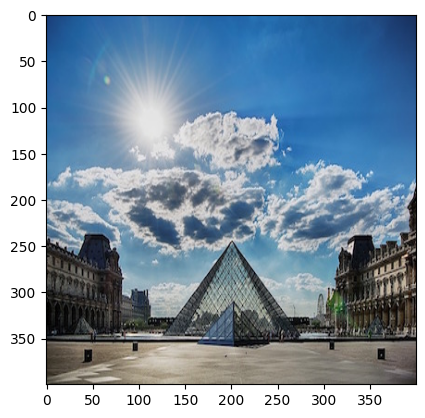

In [18]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### [5.2 Load the Style Image](#5-2)
To load, reshape, and normalize the style image (such as a painting by Claude Monet), we can follow a similar approach as with the content image.


(1, 400, 400, 3)


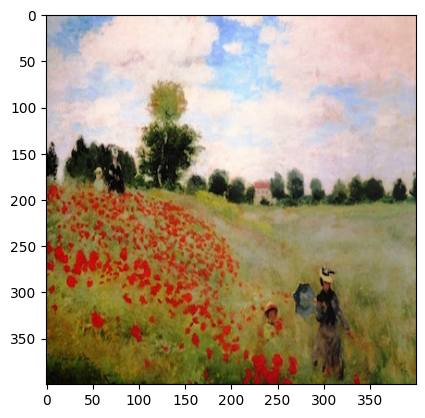

In [19]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### [5.3 Randomly Initialize the Image to be Generated](#5-3)
To create the "generated" image, we will initialize it as a noisy image that retains some correlation with the content image. This initialization strategy aids in quickly aligning the content of the generated image with that of the content image.
 

(1, 400, 400, 3)


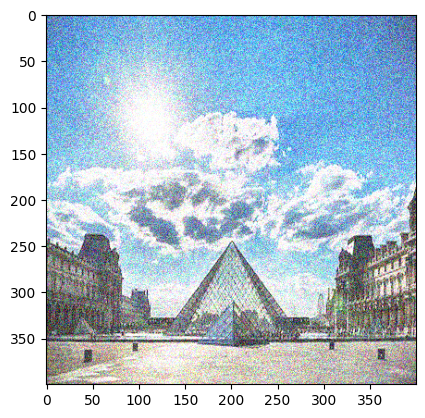

In [20]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
### [5.4 - Load Pre-trained VGG19 Model](#5-4)
Next, We will define a function that loads the VGG19 model and returns the outputs of the specified middle layers. This model will be instrumental in extracting the content and style features necessary for the Neural Style Transfer process.


In [21]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

We will define the content layer of the VGG19 model and then build the model that will be used for the Neural Style Transfer process. The content layer is crucial for capturing the content of the input image, and we will utilize the outputs of this layer in our calculations.


In [26]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

After building the model, we will extract and save the outputs for both the content and style layers. This will allow us to compute the content cost and style cost during the Neural Style Transfer process.


In [27]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
2024-11-06 12:56:04.722733: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2024-11-06 12:56:04.748187: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2024-11-06 12:56:04.764821: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2024-11-06 12:56:04.779443: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2024-11-06 12:56:04.951434: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.


<a name='5-5'></a>
### [5.5 - Compute Total Cost](#5-5)

<a name='5-5-1'></a>
#### [5.5.1 - Compute Content Cost](#5-5-1)

In this step, we will assign the appropriate hidden layer activations for the content cost computation using the activations from the `block5_conv4` layer. The process is as follows:

1. **Assign `a_C`**: Set `a_C` to the tensor that represents the hidden layer activation for the content image at the specified layer.
2. **Assign `a_G`**: Set `a_G` to the tensor that represents the hidden layer activation for the generated image at the same layer.
3. **Compute the Content Cost**: Use the previously defined function to calculate the content cost based on `a_C` and `a_G`.


In [28]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.008050359, shape=(), dtype=float32)


<a name='5-5-2'></a>
#### [5.5.2 - Compute Style Cost](#5-5-2)

In this section, we will set `a_S` to represent the hidden layer activations for the style image using the specified style layers. The activations will be collected for each layer defined in `STYLE_LAYERS`.


In [29]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
2024-11-06 13:03:26.171672: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at matmul_op_impl.h:960 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[160000,160000] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
2024-11-06 13:03:26.171724: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[160000,160000] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu


ResourceExhaustedError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[160000,160000] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:MatMul] name: 

### [5.6 - Train the Model](#5-6)

#### [5.6.1 - Image Display Utilities](#5-6-1)
To visualize the images generated by the style transfer model, we can use the following utility functions. These functions will help us display the content image, style image, and generated image in a format that is easy to interpret.


In [36]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)


#### [5.6.2 - Implementing a train_step](#5-6-2)

 
In this section, we will implement the `train_step` function, responsible for performing a single optimization step using the Adam optimizer. The function utilizes TensorFlow's `tf.GradientTape` to calculate gradients and update the generated image to minimize the total cost $J$.

**Function Purpose:**
The `train_step` function performs the following tasks:

1. **Input Parameters:**
   - The current generated image.
   - The content image.
   - The style image.

2. **Set Weights:**
   - Define hyperparameters $\alpha = 10 $ and $\beta = 40$ to control the relative weighting of the content cost and the style cost, respectively.

3. **Compute Outputs:**
   - Use the VGG19 model to obtain the outputs (activations) for the generated image.

4. **Calculate Costs:**
   - Compute the content cost by comparing the activations of the generated image to the activations of the content image.
   - Compute the style cost by comparing the Gram matrices of the style image and the generated image across multiple layers.

5. **Total Cost Calculation:**
   - Combine the content cost and the style cost to obtain the total cost $J$ using the defined weights.

6. **Gradient Calculation:**
   - Utilize `tf.GradientTape` to compute the gradients of the total cost with respect to the generated image.

7. **Optimizer Application:**
   - Create an Adam optimizer with a specified learning rate = 0.03.
   - Apply the gradients to update the generated image.

8. **Return Value:**
   - Return the computed total cost for the current training step.




In [37]:
# UNQ_C5
# GRADED FUNCTION: train_step

optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        ### START CODE HERE
        
        #(1 line)
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha=10, beta=40)  
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # Use the precomputed encoded images a_S and a_C
        a_G = vgg_model_outputs(generated_image)  # Computed output for generated image

        # Compute the style cost (consider reducing layers in STYLE_LAYERS if needed)
        J_style = compute_style_cost(a_S, a_G)

        # Compute content cost
        J_content = compute_content_cost(a_C, a_G)
        
        # Compute total cost with alpha and beta values (can be adjusted based on results)
        J = total_cost(J_content, J_style, alpha=10, beta=40)

    # Calculate gradients and apply them to the generated image
    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))  # Keep image values in the range [0, 1]

    return J  # Return cost for monitoring

In [42]:
# You always must run the last cell before this one. You will get an error if not.
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)
assert type(J1) == EagerTensor, f"Wrong type {type(J1)} != {EagerTensor}"
assert np.isclose(J1, 10221.168), f"Unexpected cost for epoch 0: {J1} != {10221.168}"

J2 = train_step(generated_image)
print(J2)
assert np.isclose(J2, 6081.23541, rtol=0.05), f"Unexpected cost for epoch 1: {J2} != {6081.2354}"

print("\033[92mAll tests passed")

tf.Tensor(10221.224, shape=(), dtype=float32)
tf.Tensor(6081.4194, shape=(), dtype=float32)
All tests passed


**Expected output**
```
tf.Tensor(10221.169, shape=(), dtype=float32)
tf.Tensor(6081.1763, shape=(), dtype=float32)
```



#### [5.6.3 - Train the Model](#5-6-3)


We will run the following cell to generate an artistic image. The process typically takes about 3 minutes on a GPU for 2500 iterations. Neural Style Transfer is generally optimized using GPUs to speed up the computation.

Increasing the learning rate can accelerate the style transfer process, but this often comes at the expense of quality. Balancing the learning rate and number of iterations will help us achieve better results.

In [38]:
# Show the generated image at some epochs
# Uncoment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

AttributeError: in user code:

    File "/tmp/ipykernel_3502/3471940037.py", line 31, in train_step  *
        optimizer.apply_gradients([(grad, generated_image)])
    File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 344, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 383, in apply
        self.build(trainable_variables)
    File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/optimizers/adam.py", line 92, in build
        super().build(var_list)
    File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/utils/tracking.py", line 26, in wrapper
        return fn(*args, **kwargs)
    File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 214, in build
        self._trainable_variables_indices[self._var_key(variable)] = i
    File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 89, in _var_key
        return variable._unique_id

    AttributeError: 'SymbolicTensor' object has no attribute '_unique_id'


Now, we will run the following code cell to see the results!

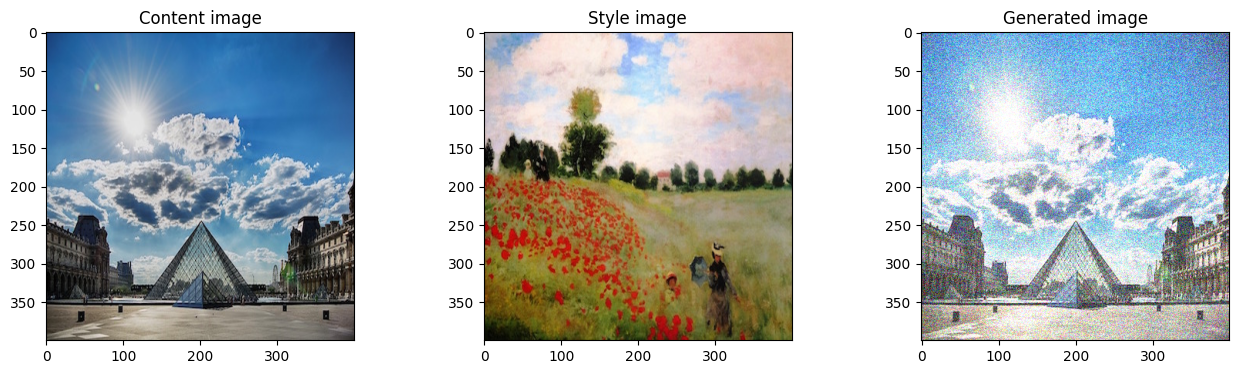

In [30]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

Look at that! You did it! After running this, in the upper bar of the notebook click on "File" and then "Open". Go to the "/output" directory to see all the saved images. Open "generated_image" to see the generated image! :)

Running for around 20000 epochs with a learning rate of 0.001, you should see something like the image presented below on the right:

<img src="images/louvre_generated.png" style="width:800px;height:300px;">

The hyperparameters were set so that you didn't have to wait too long to see an initial result. To get the best looking results, you may want to try running the optimization algorithm longer (and perhaps with a smaller learning rate). After completing and submitting this assignment, come back and play more with this notebook, and see if you can generate even better looking images. But first, give yourself a pat on the back for finishing this long assignment!


#### [5.6.4 - Generated Image Results](#5-6-4)
Upon successful completion of the process, the generated image can be found in the `/kaggle/working/output` directory of the notebook.

Typically, running the optimization process for around 20,000 epochs with a learning rate of 0.001 should yield results resembling the image shown below:

![Generated Image](images/louvre_generated.png)

The chosen hyperparameters were set to ensure an initial output is produced within a reasonable time frame. However, for enhanced visual quality, further optimization can be performed by increasing the number of iterations and potentially reducing the learning rate. This iterative process allows for refined details and improved quality in the final output.

Once the optimization is complete, further experimentation and fine-tuning of the hyperparameters can lead to even more aesthetically pleasing images. However, before proceeding, take a moment to appreciate the successful completion of this task.


Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;height:300px;">


## [6 - Conclusion](#6)

The completion of this project marks a significant achievement in applying Neural Style Transfer (NST) to generate artistic images. In this process, the optimization algorithm was employed to modify the pixel values of an image, rather than adjusting the parameters of the neural network itself. This represents an important distinction, as it demonstrates the flexibility of deep learning models in tackling tasks beyond traditional supervised learning.


### [6.1 - Key Takeaways](#6-1)
- **Neural Style Transfer (NST)** is an algorithm that can generate an artistic image by combining a content image $C$ with a style image $S$.
- The approach utilizes feature representations, specifically hidden layer activations, from a pretrained Convolutional Neural Network (CNN).
- The **content cost** function is derived from the activations of a single hidden layer, capturing the content information from the image.
- The **style cost** function for a layer is computed using the Gram matrix of that layer's activations, which reflects the correlations between different features in the image. The overall style cost is aggregated across multiple layers.
- By minimizing the total cost function, the optimization process synthesizes a new image that blends both content and style characteristics.

As deep learning continues to evolve, Neural Style Transfer serves as an example of how these techniques can be applied in creative and artistic domains. Moving forward, there are numerous opportunities for exploring the extension of this methodology, whether through improving optimization efficiency or expanding its application to video or interactive media.


<a name='7'></a>
## [7 - References](#7)


The Neural Style Transfer (NST) algorithm was pioneered by Gatys et al. (2015). The pre-trained network employed in this implementation is a VGG network, as developed by Simonyan and Zisserman (2015). The pre-trained weights utilized in this study were provided by the MathConvNet team.

- Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576).
- Narayanan, H. [Convolutional Neural Networks for Artistic Style Transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0. [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Simonyan, K., & Zisserman, A. (2015). [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf).
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
